In [180]:
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
print(umap.__file__)
import numpy as np
import MDAnalysis as mda
import MDAnalysis.analysis.distances as mda_distances
import deeptime
import MDAnalysis.analysis.align as align


/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/umap/__init__.py


In [181]:

u = mda.Universe("md-564.gro", "md_traj-all.xtc")
# Aligner la trajectoire pour supprimer translations et rotations
print("Alignement de la trajectoire...")
ref = mda.Universe("md-564.gro")
ref_selection = ref.select_atoms("(resid 600-635 and name BB) or (resid 715-750 and name BB)")
aligner = align.AlignTraj(u, ref, select="(resid 600-635 and name BB) or (resid 715-750 and name BB)", in_memory=True)
aligner.run()
selection = u.select_atoms("(resid 600-635 and name BB) or (resid 715-750 and name BB)")
coordinates = []
print("Collecte des coordonnées...")
for ts in tqdm(u.trajectory):
    coords = selection.positions.flatten()  # Aplatir en un vecteur 1D (N_atomes * 3)
    coordinates.append(coords)

coordinates = np.array(coordinates)

n_frames, n_features = coordinates.shape
print(f"Nombre d'atomes sélectionnés: {len(selection)}")
print(f"Nombre de features (N_atomes * 3): {n_features}")
print(f"Forme du tableau de coordonnées: {coordinates.shape}")


Alignement de la trajectoire...
Collecte des coordonnées...


100%|██████████| 7224/7224 [00:00<00:00, 152444.94it/s]

Nombre d'atomes sélectionnés: 72
Nombre de features (N_atomes * 3): 216
Forme du tableau de coordonnées: (7224, 216)


In [182]:

models = ["ROSE", "TR", "AFM", "ESM", "OMEGA", "AF"]
colors = ["cyan", "green", "pink", "gold", "darkblue", "red"]
frames_per_model = 1204


In [183]:
coordinates = coordinates/10
coordinates_centered = coordinates - np.mean(coordinates, axis=0)

Exécution de la PCA...
Variance expliquée par les composantes: [0.29424524 0.2070275 ]
Pourcentage total de variance expliquée: 50.13%


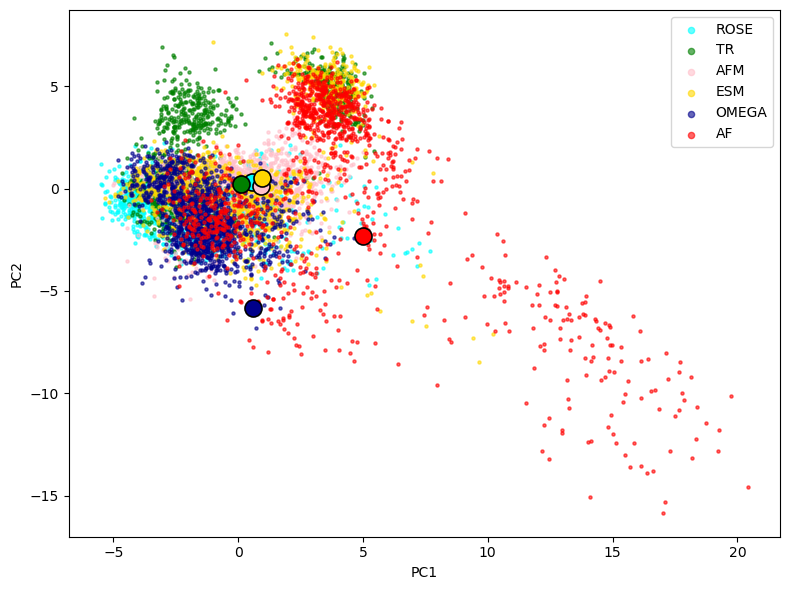

In [184]:
# 1. PCA
print("Exécution de la PCA...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(coordinates_centered)

print(f"Variance expliquée par les composantes: {pca.explained_variance_ratio_}")
print(f"Pourcentage total de variance expliquée: {sum(pca.explained_variance_ratio_)*100:.2f}%")
pca_result[:, 0] = -pca_result[:, 0]

plt.figure(figsize=(8, 6))
for idx, (model, color) in enumerate(zip(models, colors)):
    start = idx * frames_per_model
    end = start + frames_per_model


    plt.scatter(
        pca_result[start:end, 0],
        pca_result[start:end, 1],
        s=5, alpha=0.6, color=color,
        label=model
    )

    # Afficher une étoile au début de chaque modèle
    frame_index = start
    x_star = pca_result[frame_index, 0]
    y_star = pca_result[frame_index, 1]
    plt.scatter(x_star, y_star, color=color, marker='o', s=150,
            linewidths=1.2, edgecolors='black' ,zorder=2 )

    #plt.text(x_star + 0.1, y_star, str(frame_index), fontsize=10, color=color)


#plt.title("Projection PCA des coordonnées avec début de chaque modèle")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=10)
plt.tight_layout()
plt.savefig("pca_model_start_frames.png", dpi=300)
plt.show()

In [186]:
from deeptime.decomposition import TICA
import matplotlib.pyplot as plt
lagtime = 10  # lag time (en frames)
dim = 10    # nombre de composantes à conserver

print("Exécution de l'analyse tICA...")
tica = deeptime.decomposition.TICA(lagtime=lagtime, dim=dim)
tica_model = tica.fit(coordinates).fetch_model()
tica_output = tica.transform(coordinates)

Exécution de l'analyse tICA...


In [187]:


# 1) Récupérer les valeurs singulières (i.e. les "eigenvalues")
sv = tica_model.singular_values       
kinetic_variance = sv**2

# Fraction de variance expliquée et somme cumulée
explained_ratio   = kinetic_variance / kinetic_variance.sum()
cumulative_ratio  = np.cumsum(explained_ratio)
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(np.arange(1, len(cumulative_ratio)+1), cumulative_ratio, marker='o')
ax.set_xlabel("Nombre de composantes tICA")
ax.set_ylabel("Variance cinétique cumulée")
ax.set_title("Variance expliquée par tICA")
ax.grid(True)
plt.tight_layout()
plt.savefig("tica_variance_cumulee.png")
plt.close()

In [188]:

timescales = tica_model.timescales()  
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(np.arange(1, len(timescales)+1), timescales)
ax.set_xlabel("Composante tICA")
ax.set_ylabel("Implied timescale (frames)")
ax.set_title("Temps caractéristiques tICA")
ax.grid(True, axis='y')
plt.tight_layout()
plt.savefig("tica_timescales.png")
plt.close()

In [189]:

tica_model = tica.fetch_model()
tica_proj = tica_model.transform(coordinates)  
# -> array de shape (n_frames, dim)

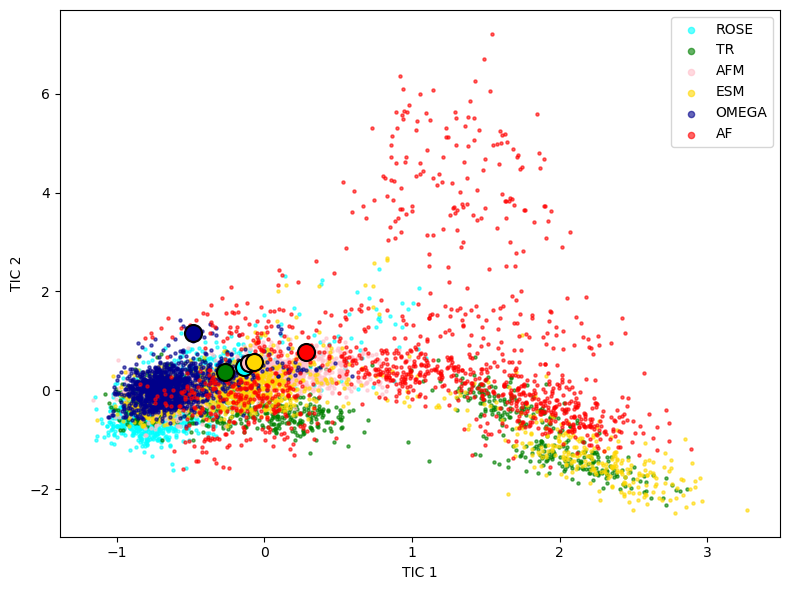

In [190]:

# Définition des modèles et couleurs
models = ["ROSE", "TR", "AFM", "ESM", "OMEGA", "AF"]
colors = ["cyan", "green", "pink", "gold", "darkblue", "red"]
frames_per_model = 1204

# Création de la figure
plt.figure(figsize=(8, 6))

# Boucle sur chaque modèle
for idx, (model, color) in enumerate(zip(models, colors)):
    start = idx * frames_per_model
    end = start + frames_per_model

    #Scatter du bloc
    plt.scatter(
        tica_proj[start:end, 0],
        tica_proj[start:end, 1],
        s=5, alpha=0.6, color=color,
        label=model
    )

    frame_index = start
    x_star = tica_proj[frame_index, 0]
    y_star = tica_proj[frame_index, 1]

    plt.scatter(x_star, y_star, color=color, marker='o', s=150, linewidths=1.5, edgecolors='black', zorder=2 )
    #plt.text(x_star + 0.1, y_star, str(frame_index), fontsize=10, color='black')

# Finalisation
#plt.title("Projection tICA avec début de chaque modèle")
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.legend(markerscale=2, fontsize=10)
plt.tight_layout()
plt.savefig("tica_model.png", dpi=300)
plt.show()


In [191]:
#Clustering

from sklearn_extra.cluster import KMedoids
import numpy as np
import matplotlib.pyplot as plt

# Clustering KMedoids
n_clusters = 5
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, method='pam', init='k-medoids++')
cluster_assignments = kmedoids.fit_predict(tica_proj)

# Indices et coordonnées des centres
medoid_indices = kmedoids.medoid_indices_
medoid_points = tica_proj[medoid_indices]

# Sauvegarder les résultats pour réutilisation
np.save("medoid_indices.npy", medoid_indices)
np.save("cluster_assignments.npy", cluster_assignments)


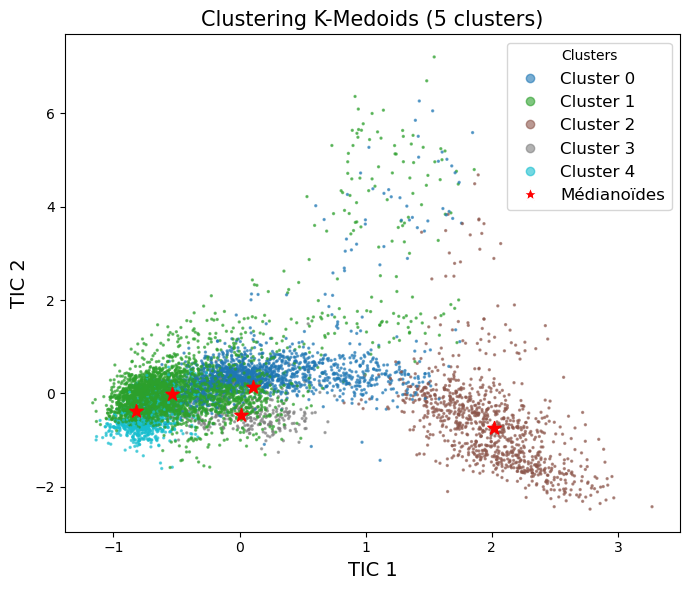

In [192]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import numpy as np

# Nombre de clusters (états métastables)
n_clusters = 5

# Clustering KMedoids sur la projection TICA
kmedoids = KMedoids(n_clusters=n_clusters, random_state=43, method='pam',init='heuristic',metric='euclidean')
cluster_assignments = kmedoids.fit_predict(tica_proj)

# Centres des clusters (vrais points issus de la trajectoire)
medoid_indices = kmedoids.medoid_indices_
medoid_points = tica_proj[medoid_indices]

# Affichage
plt.figure(figsize=(7, 6))
scatter = plt.scatter(tica_proj[:, 0], tica_proj[:, 1],
                      c=cluster_assignments, cmap='tab10', s=2, alpha=0.6)

# Afficher les medoids (centres réels) comme des étoiles rouges
plt.scatter(medoid_points[:, 0], medoid_points[:, 1],
            c='red', s=100, marker='*', label='Center')

# Légende
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6)
labels = [f"Cluster {i}" for i in range(n_clusters)]
plt.legend(handles + [plt.Line2D([0], [0], marker='*', color='w', label='center',
                                 markerfacecolor='red', markersize=10)],
           labels + ['Médianoïdes'], title="Clusters", loc="upper right", fontsize=12)

plt.xlabel("TIC 1", fontsize=14)
plt.ylabel("TIC 2", fontsize=14)
plt.title(f"Clustering K-Medoids ({n_clusters} clusters)", fontsize=15)
plt.tight_layout()
plt.savefig("tica_kmedoids_clusters.png", dpi=300)
plt.show()


In [193]:
for i, frame_idx in enumerate(medoid_indices):
    u.trajectory[frame_idx]
    u.atoms.write(f"cluster_{i}_center.pdb")

/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'chainIDs' Using default value of ''
  warnings.warn("Found no information for attr: '{}'"
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1153: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/pytho

/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/ibpc/lumo/sritharan/.conda/envs/tICA/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/ibpc/lumo/srith

✅ Figure enregistrée : all_cluster_centers_contacts.png


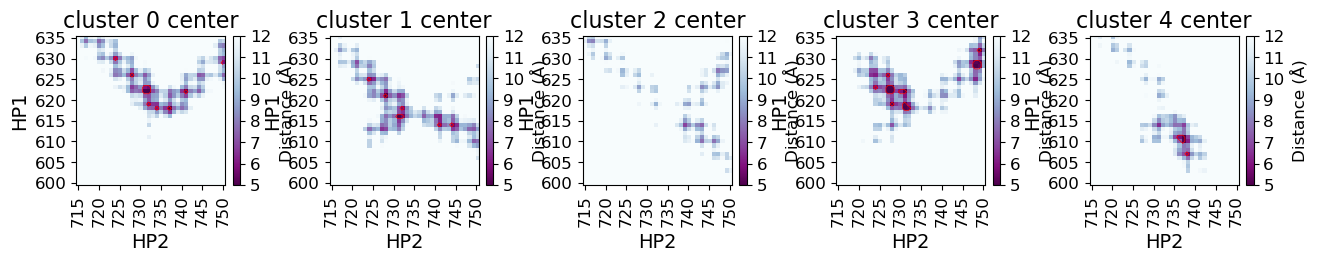

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import os
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Liste des fichiers modèles représentant les centres des clusters
models = [f"cluster_{i}_center.pdb" for i in range(n_clusters)]

# Création de la figure
nrows = 1
ncols = n_clusters
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))

# Boucle sur les modèles
for i, (ax, model) in enumerate(zip(axs.flat, models)):
    if not os.path.isfile(model):
        print(f"[!] Fichier non trouvé : {model}")
        continue

    u = mda.Universe(model)
    HP1_bb = u.select_atoms('name BB and resid 600-635')
    HP2_bb = u.select_atoms('name BB and resid 715-750')
    
    n_HP1 = len(HP1_bb)
    n_HP2 = len(HP2_bb)

    # Vérification rapide
    if n_HP1 == 0 or n_HP2 == 0:
        print(f"[!] Problème de sélection dans {model}")
        continue

    # Calcul de la matrice de distances
    dist_arr = distances.distance_array(HP1_bb.positions, HP2_bb.positions, box=u.dimensions)

    # Sauvegarde de la matrice en CSV
    out_csv = model.replace(".pdb", "_contacts.csv")
    np.savetxt(out_csv, dist_arr, delimiter=',')

    # Affichage de la heatmap
    cmap = 'BuPu_r'
    vmin = 5
    vmax = 12

    im = ax.imshow(dist_arr, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')

    # Contour pour les contacts proches (< 6 Å)
    contact_map = dist_arr < 6
    ax.contour(contact_map, levels=[0.5], colors='red', linewidths=0.5)

    # Ticks et labels
    tick_interval = 5
    ax.set_yticks(np.arange(n_HP1)[::tick_interval])
    ax.set_xticks(np.arange(n_HP2)[::tick_interval])
    ax.set_yticklabels(HP1_bb.resids[::tick_interval], fontsize=12)
    ax.set_xticklabels(HP2_bb.resids[::tick_interval], fontsize=12, rotation=90)
    ax.set_ylabel('HP1', fontsize=14)
    ax.set_xlabel('HP2', fontsize=14)

    # Titre
    cluster_title = os.path.basename(model).replace('_', ' ').split('.')[0]
    ax.set_title(f"{cluster_title}", fontsize=16)

    # Ajout d’une colorbar individuelle
    axins = inset_axes(ax,
                       width="5%",
                       height="100%",
                       loc='lower left',
                       bbox_to_anchor=(1.05, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0)
    cbar = fig.colorbar(im, cax=axins)
    cbar.set_ticks(np.arange(5, 13, 1))
    cbar.set_label('Distance (Å)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)

# Ajustement et sauvegarde de la figure finale
plt.subplots_adjust(wspace=0.7, hspace=0.3)
plt.savefig("all_cluster_centers_contacts.png", dpi=300, transparent=True)
print("✅ Figure enregistrée : all_cluster_centers_contacts.png")


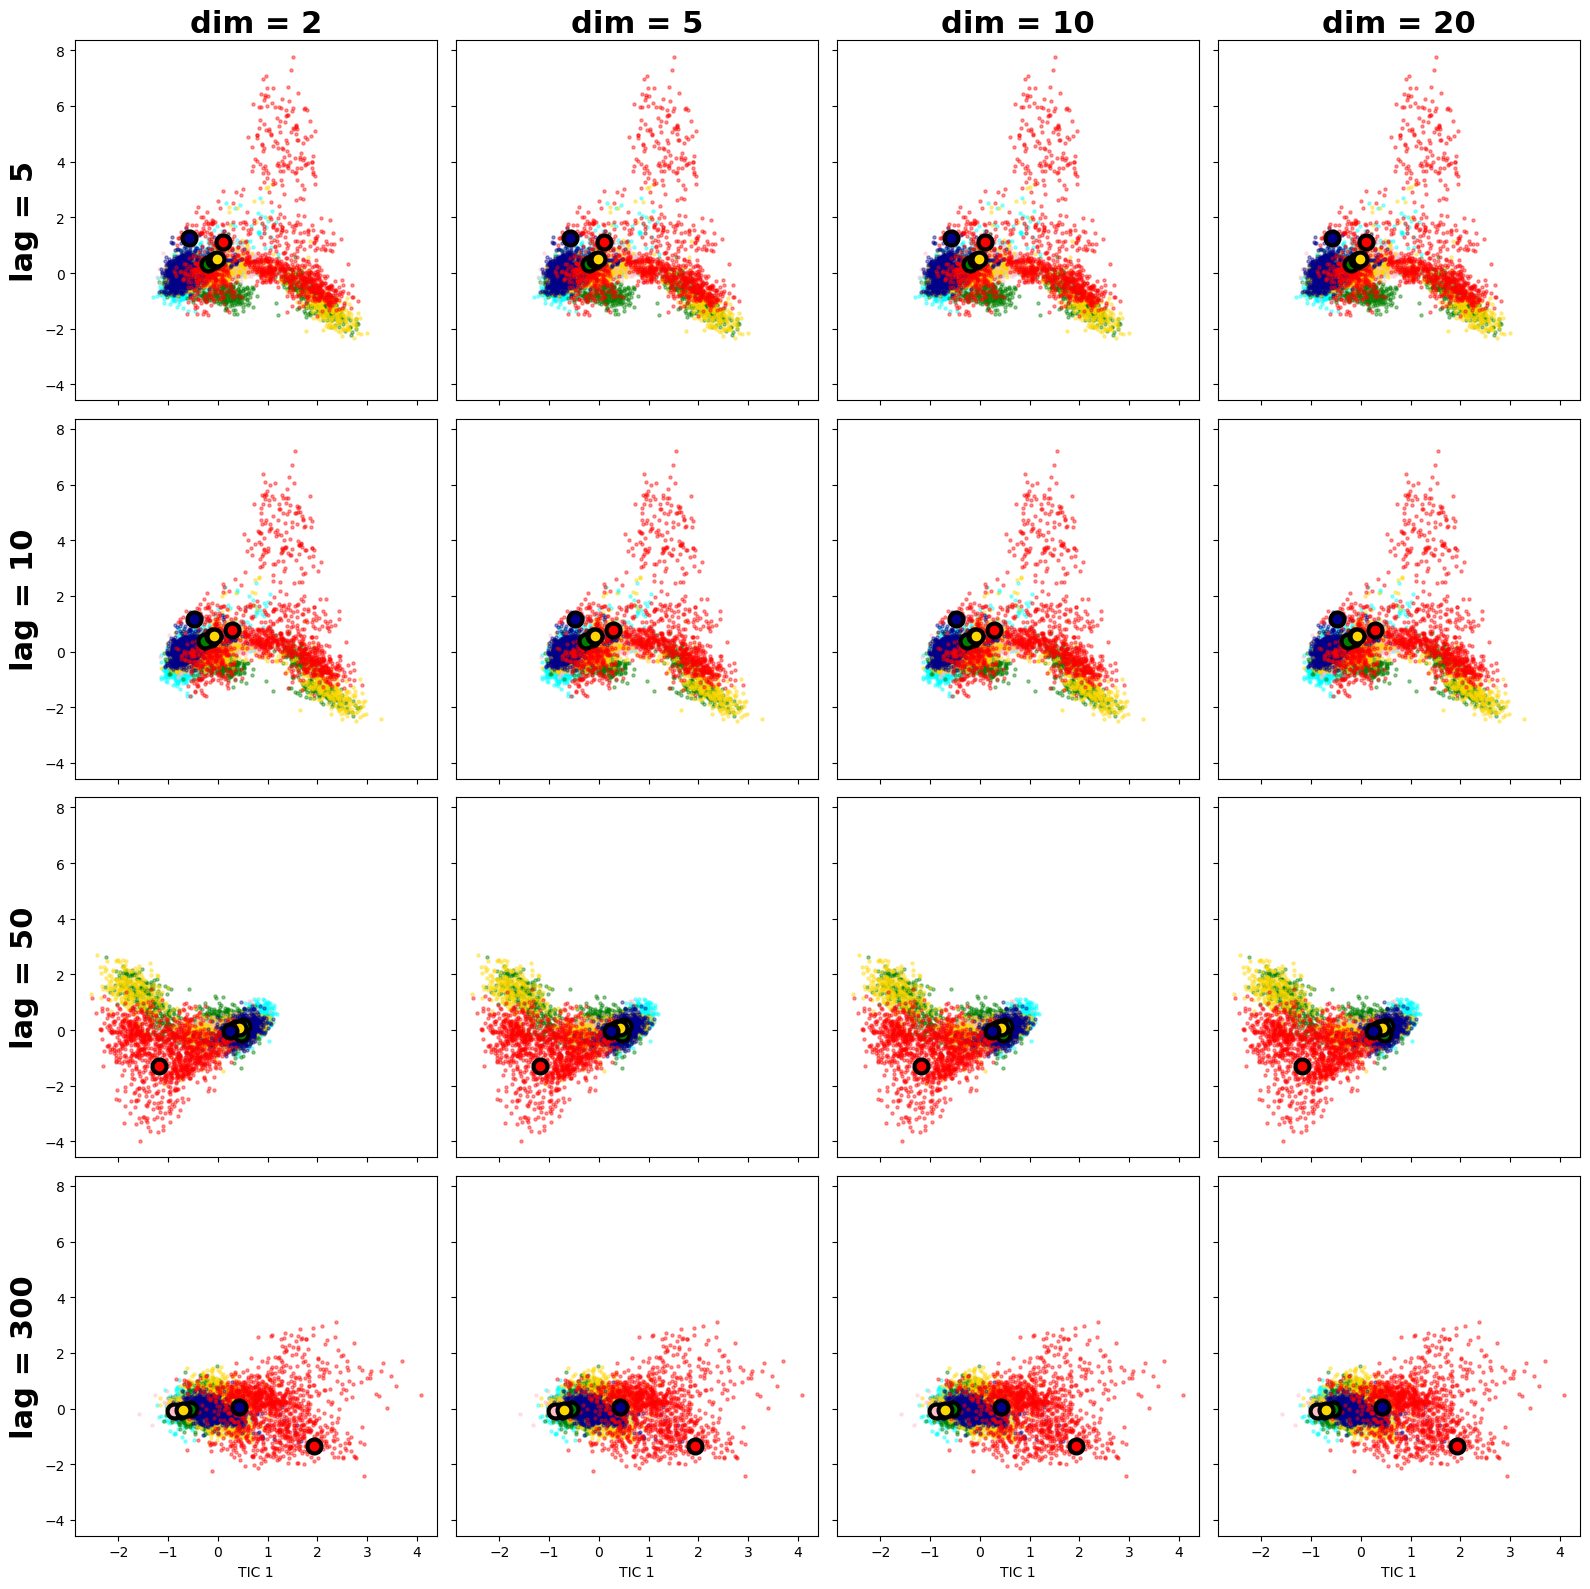

In [195]:
import deeptime.decomposition as dd
import matplotlib.pyplot as plt

# Vos paramètres
lagtimes = [5, 10, 50, 300]
dims     = [2, 5, 10, 20]

models = ["ROSE", "TR", "AFM", "ESM", "OMEGA", "AF"]
colors = ["cyan", "green", "pink", "gold", "darkblue", "red"]
frames_per_model = 1204  # n° de frames par modèle

# Création de la figure avec une grille de subplots
fig, axes = plt.subplots(
    nrows=len(lagtimes),
    ncols=len(dims),
    figsize=(4 * len(dims), 4 * len(lagtimes)),
    sharex=True,
    sharey=True
)

for i, lag in enumerate(lagtimes):
    for j, dim in enumerate(dims):
        ax = axes[i, j]
        
        # TICA pour cette combinaison
        tica = dd.TICA(lagtime=lag, dim=dim)
        model = tica.fit(coordinates).fetch_model()
        proj  = model.transform(coordinates)  # shape = (n_frames, dim)
        
        # Scatter de chaque modèle
        for idx, (name, color) in enumerate(zip(models, colors)):
            start = idx * frames_per_model
            end   = start + frames_per_model
            
            ax.scatter(
                proj[start:end, 0],
                proj[start:end, 1],
                s=5, alpha=0.4, color=color
            )
            # marqueur du premier frame de chaque bloc
            x0, y0 = proj[start, 0], proj[start, 1]
            ax.scatter(
                x0, y0,
                marker='o', s=100, edgecolors='black', facecolor=color,linewidths=3, zorder=2 
            )
        
        # Titres des axes et annotations
        if i == 0:
            ax.set_title(f"dim = {dim}", fontsize=22,fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"lag = {lag}", fontsize=22,fontweight='bold')
        if i == len(lagtimes) - 1:
            ax.set_xlabel("TIC 1")
        #if j == len(dims) - 1:
            #ax.legend(models, fontsize=6, markerscale=1.5, loc='upper right')
        
# Ajustements finaux
plt.tight_layout(h_pad=1.0, w_pad=1.0)
plt.savefig("tica_panel_dim_lagtime.png", dpi=300)
plt.show()


In [1]:
!pip freeze > requirements.txt
